In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. Chuẩn bị dataset



In [ ]:
doh_path = '/content/drive/MyDrive/GbFS/l1-doh.csv'
doh = pd.read_csv(doh_path)

non_doh_path = '/content/drive/MyDrive/GbFS/l1-nondoh.csv'
non_doh = pd.read_csv(non_doh_path)

benign_path = '/content/drive/MyDrive/GbFS/l2-benign.csv'
benign = pd.read_csv(benign_path)

mal_path = '/content/drive/MyDrive/GbFS/l2-malicious.csv'
mal = pd.read_csv(mal_path)

In [ ]:
dataset_l1 = pd.concat([doh, non_doh], ignore_index=True)
dataset_l2 = pd.concat([benign, mal], ignore_index=True)

## Normalize và scaling

In [ ]:
def min_max_scaling(data):
  scaled_dataset = (data-data.min())/(data.max()-data.min())
  return scaled_dataset

In [ ]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder

def label_encoding(data):
  # Creating a instance of label Encoder.
  le = LabelEncoder()

  str_columns = data.select_dtypes(include=['object']).columns
  for col in str_columns:
      data[col] = le.fit_transform(data[col].astype(str))
  # printing label
  sample = pd.concat([data.head(), data.tail()], ignore_index=True)
  sample
  return data

In [ ]:
dataset_l1 = label_encoding(dataset_l1)
dataset_l2 = label_encoding(dataset_l2)

In [ ]:
dataset_l1 = min_max_scaling(dataset_l1)
dataset_l2 = min_max_scaling(dataset_l2)

# 2. Xây dựng model

In [ ]:
import random

def initialize_pop(NUM_FEATURES):
    """
    Khởi tạo quần thể ban đầu.

    Parameters:
    NUM_FEATURES (int): Số lượng đặc trưng.

    Returns:
    list: Danh sách các chromosome trong quần thể ban đầu.
    """
    population = []
    for _ in range(POP_SIZE):
        chromosome = [random.choice([0, 1]) for _ in range(NUM_FEATURES)]
        population.append(chromosome)
    return population

def fitness_function(data, chromosome):
    """
    Tính toán hiệu suất của một chromosome dựa trên độ chính xác của mô hình học máy.

    Parameters:
    data (DataFrame): Dữ liệu ban đầu.
    chromosome (array-like): Các đặc trưng được chọn từ chromosome.

    Returns:
    float: Độ chính xác của mô hình học máy sử dụng các đặc trưng từ chromosome.
    """
    # Chọn các đặc trưng từ chromosome
    selected_features = [i for i, bit in enumerate(chromosome) if bit == 1]
    X = data.iloc[:, selected_features].values
    y = data['Label'].values

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Huấn luyện mô hình hồi quy logistic
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Đánh giá độ chính xác của mô hình trên tập kiểm tra
    accuracy = model.score(X_test, y_test)

    return accuracy

def calculate_fitness_values(data, population):
    """
    Tính toán giá trị Fitness cho toàn bộ quần thể.

    Parameters:
    data (DataFrame): Dữ liệu gốc.
    population (list): Danh sách các cá thể trong quần thể.

    Returns:
    list: Danh sách các giá trị Fitness tương ứng với mỗi cá thể trong population.
    """
    fitness_values = []
    for chromosome in population:
        fitness_value = fitness_function(data, chromosome)
        fitness_values.append(fitness_value)
    return fitness_values

def roulette_wheel_selection(population, fitness_values):
    """
    Lựa chọn các cá thể cha mẹ sử dụng phương pháp bánh xe quay.

    Parameters:
    population (list): Danh sách các cá thể trong quần thể.
    fitness_values (list): Danh sách các giá trị Fitness tương ứng với mỗi cá thể trong population.

    Returns:
    tuple: Một cặp cha mẹ được chọn từ quần thể.
    """
    total_fitness = sum(fitness_values)
    selection_point = random.uniform(0, total_fitness)
    current_sum = 0

    for i, fitness in enumerate(fitness_values):
        current_sum += fitness
        if current_sum >= selection_point:
            parent1 = population[i]
            break

    current_sum = 0
    selection_point = random.uniform(0, total_fitness)
    for i, fitness in enumerate(fitness_values):
        current_sum += fitness
        if current_sum >= selection_point:
            parent2 = population[i]
            break

    return parent1, parent2

def mutation(parent, mutation_rate):
    """
    Thực hiện toán tử đột biến (mutation) trên một cá thể cha mẹ.

    Parameters:
    parent (list): Cá thể cha mẹ.
    mutation_rate (float): Tỷ lệ đột biến.

    Returns:
    list: Cá thể con sau khi đột biến.
    """
    child = parent[:]  # Sao chép cá thể cha mẹ
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] = random.choice([0, 1])  # Thực hiện đột biến
    return child

def crossover(parent1, parent2):
    """
    Thực hiện toán tử lai ghép (crossover) giữa hai cá thể cha mẹ.

    Parameters:
    parent1 (list): Cá thể cha mẹ thứ nhất.
    parent2 (list): Cá thể cha mẹ thứ hai.

    Returns:
    list: Cá thể con sau khi lai ghép.
    """
    crossover_point = len(parent1) // 2
    child = parent1[:crossover_point] + parent2[crossover_point:]
    return child

def new_population(population, fitness_values):
    new_population = []
    for _ in range(POP_SIZE):
      parent1, parent2 = roulette_wheel_selection(population, fitness_values)
      # Lai ghép
      child = crossover(parent1, parent2)

      # Đột biến
      mutated_child = mutation(child, MUT_RATE)

      # Thêm con vào quần thể mới
      new_population.append(mutated_child)
    return new_population

def find_best_chromosome(data, population, num_generations, max_generations_without_improvement):
    best_fitness = -float('inf')  # Khởi tạo best_fitness với giá trị âm vô cực
    best_chromosome = None

    num_generations_without_improvement = 0

    # Vòng lặp qua các thế hệ
    for generation in range(num_generations):
        # Tính toán fitness cho mỗi cá thể trong quần thể
        fitness_values = calculate_fitness_values(data, population)

        # Tìm fitness tốt nhất trong thế hệ hiện tại
        max_fitness_in_generation = max(fitness_values)

        # Kiểm tra xem có sự cải thiện so với best_fitness hay không
        if max_fitness_in_generation > best_fitness:
            best_fitness = max_fitness_in_generation
            best_chromosome_index = fitness_values.index(max_fitness_in_generation)
            best_chromosome = population[best_chromosome_index]
            num_generations_without_improvement = 0
        else:
            num_generations_without_improvement += 1

        # Kiểm tra tiêu chí dừng: số thế hệ không có cải thiện vượt quá ngưỡng cho phép
        if num_generations_without_improvement >= max_generations_without_improvement:
            break

    return best_chromosome

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from imblearn.over_sampling import SMOTE

def classification(data, best_chromosome, classifier, num_folds=5, threshold=0.5):
    """
    Hàm thực hiện quá trình phân loại sử dụng các bộ phân loại khác nhau.

    Parameters:
    - data (DataFrame): Dữ liệu đầu vào.
    - best_chromosome (list): Tập hợp các đặc trưng tối ưu.
    - classifier (str): Bộ phân loại được sử dụng, có thể là 'svm', 'knn', hoặc 'xgboost'.
    - num_folds (int): Số lượng fold trong cross-validation.
    - threshold (float): Ngưỡng phân loại.

    Returns:
    - accuracy (float): Độ chính xác trung bình của mô hình.
    - recall (float): Recall trung bình của mô hình.
    """
    # Lựa chọn các đặc trưng từ tập dữ liệu dựa trên best_chromosome
    selected_features = data.iloc[:, [i for i, bit in enumerate(best_chromosome) if bit == 1]]
    X = selected_features.values
    y = data['Label'].values  # Giả sử cột 'Label' là cột nhãn

    # Sử dụng SMOTE để làm cân bằng dữ liệu
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=42)

    # Chọn bộ phân loại
    if classifier == 'svm':
        clf = SVC(
                kernel='linear',    # Sử dụng kernel tuyến tính để phân loại dữ liệu.
                C=1.0,              # Hệ số phạt lỗi tiêu chuẩn, cân bằng giữa độ chính xác và khả năng tổng quát hóa.
                gamma='scale',      # Hệ số gamma, tuy nhiên, với kernel tuyến tính, tham số này không được sử dụng.
                class_weight='balanced', # Điều chỉnh trọng số lớp tự động để xử lý dữ liệu không cân bằng.
                probability=True    # Tính toán xác suất dự đoán.
            )
    elif classifier == 'knn':
          clf = KNeighborsClassifier(
                n_neighbors=9,        # Số lượng láng giềng gần nhất được sử dụng để dự đoán.
                weights='distance',   # Láng giềng gần hơn có trọng số cao hơn.
                algorithm='auto',     # Tự động chọn thuật toán tối ưu nhất cho dữ liệu.
                p=2,                  # Sử dụng khoảng cách Euclidean (L2).
                metric='minkowski'    # Sử dụng khoảng cách Minkowski (tổng quát).
          )
    elif classifier == 'xgboost':
         clf = XGBClassifier(
                learning_rate=0.1,    # Tốc độ học của mô hình, giúp làm chậm quá trình học để tránh overfitting.
                n_estimators=100,     # Tăng số lượng cây để cải thiện hiệu suất và độ chính xác của mô hình.
                max_depth=5,          # Độ sâu tối đa của mỗi cây, giữ nguyên để cân bằng giữa độ chính xác và khả năng tổng quát hóa.
                gamma=0,              # Giảm giá trị gamma để cho phép chia tách nhiều hơn, cải thiện khả năng học của mô hình.
                subsample=0.8,        # Tăng tỷ lệ mẫu được sử dụng để xây dựng mỗi cây, giảm khả năng underfitting.
                colsample_bytree=0.8  # Tăng tỷ lệ cột được sử dụng để xây dựng mỗi cây, giảm khả năng underfitting.
            )
    else:
        raise ValueError("Invalid classifier. Please choose from 'svm', 'knn', or 'xgboost'.")

    # Huấn luyện mô hình
    clf.fit(X_train, y_train)

    # Dự đoán xác suất
    y_probs = clf.predict_proba(X_test)[:, 1]

    # Áp dụng ngưỡng phân loại
    y_pred = (y_probs >= threshold).astype(int)

    # Tính recall và accuracy
    recall = recall_score(y_test, y_pred, average='macro')
    accuracy = (y_test == y_pred).mean()

    return accuracy, recall


# 3. Train model

In [ ]:
POP_SIZE = 100
MUT_RATE = 0.5

## Dataset L1: doh & non_doh

In [ ]:
NUM_FEATURES_l1 = len(dataset_l1.columns) - 1  # Số lượng đặc trưng trong dataset (trừ đi 1 cột nhãn)
FEATURES_l1 = dataset_l1.columns[:-1]  # Danh sách các đặc trưng trong dataset

In [ ]:
# Khởi tạo quần thể ban đầu
population_l1 = initialize_pop(NUM_FEATURES_l1)

In [ ]:
# Sử dụng hàm calculate_fitness_values để tính toán fitness_values cho population
fitness_values_l1 = calculate_fitness_values(dataset_l1, population_l1)

In [ ]:
population_l1 = new_population(population_l1, fitness_values_l1)

In [ ]:
best_chromosome_l1 = find_best_chromosome(dataset_l1, population_l1, 100, 10)

## Dataset L2: benign & malicious

In [ ]:
NUM_FEATURES_l2 = len(dataset_l2.columns) - 1  # Số lượng đặc trưng trong dataset (trừ đi 1 cột nhãn)
FEATURES_l2 = dataset_l2.columns[:-1]  # Danh sách các đặc trưng trong dataset

In [ ]:
# Khởi tạo quần thể ban đầu
population_l2 = initialize_pop(NUM_FEATURES_l2)

In [ ]:
# Sử dụng hàm calculate_fitness_values để tính toán fitness_values cho population
fitness_values_l2 = calculate_fitness_values(dataset_l2, population_l2)

In [ ]:
population_l2 = new_population(population_l2, fitness_values_l2)

In [ ]:
best_chromosome_l2 = find_best_chromosome(dataset_l2, population_l2, 100, 10)

# 4. Đánh giá

## Dataset L1: doh & non_doh

In [ ]:
knn_accuracy_l1, knn_recall_l1 = classification(dataset_l1, best_chromosome_l1, classifier='knn')
print("KNN accuracy L1: ", knn_accuracy_l1)
print("KNN recall L1: ", knn_recall_l1)

KNN accuracy L1:  0.976100278551532
KNN recall L1:  0.9761162454069703


In [ ]:
xgboost_accuracy_l1, xgboost_recall_l1 = classification(dataset_l1, best_chromosome_l1, classifier='xgboost')
print("XGBoost accuracy L1: ", xgboost_accuracy_l1)
print("XGBoost recall L1: ", xgboost_recall_l1)

XGBoost accuracy L1:  0.9661281337047354
XGBoost recall L1:  0.9661342265293678


In [ ]:
svm_accuracy_l1, svm_recall_l1 = classification(dataset_l1, best_chromosome_l1, classifier='svm')
print("SVM accuracy L1: ", svm_accuracy_l1)
print("SVM recall L2: ", svm_recall_l1)

SVM accuracy L1:  0.8836211699164346
SVM recall L2:  0.8836272631103914


## Dataset L2: benign & malicious

In [ ]:
xgboost_accuracy_l2, xgboost_recall_l2 = classification(dataset_l2, best_chromosome_l2, classifier='xgboost')
print("XGBoost accuracy L2: ", xgboost_accuracy_l2)
print("XGBoost recall L2: ", xgboost_recall_l2)

XGBoost accuracy L2:  0.9405643386031619
XGBoost recall L2:  0.9399879508069817


In [ ]:
knn_accuracy_l2, knn_recall_l2 = classification(dataset_l2, best_chromosome_l2, classifier='knn')
print("KNN accuracy L2: ", knn_accuracy_l2)
print("KNN recall L2: ", knn_recall_l2)

KNN accuracy L2:  0.9165499299579748
KNN recall L2:  0.9165220752819732


In [ ]:
svm_accuracy_l2, svm_recall_l2 = classification(dataset_l2, best_chromosome_l2, classifier='svm')
print("SVM accuracy L2: ", svm_accuracy_l2)
print("SVM recall L2: ", svm_recall_l2)

SVM accuracy L2:  0.9413648188913348
SVM recall L2:  0.9410645729684577


## Tổng quát

SVM accuracy:  0.9124929944038846
SVM recall:  0.9123459180394246
KNN accuracy:  0.9463251042547534
KNN recall:  0.9463191603444717
XGBoost accuracy:  0.9533462361539486
XGBoost recall:  0.9530610886681747


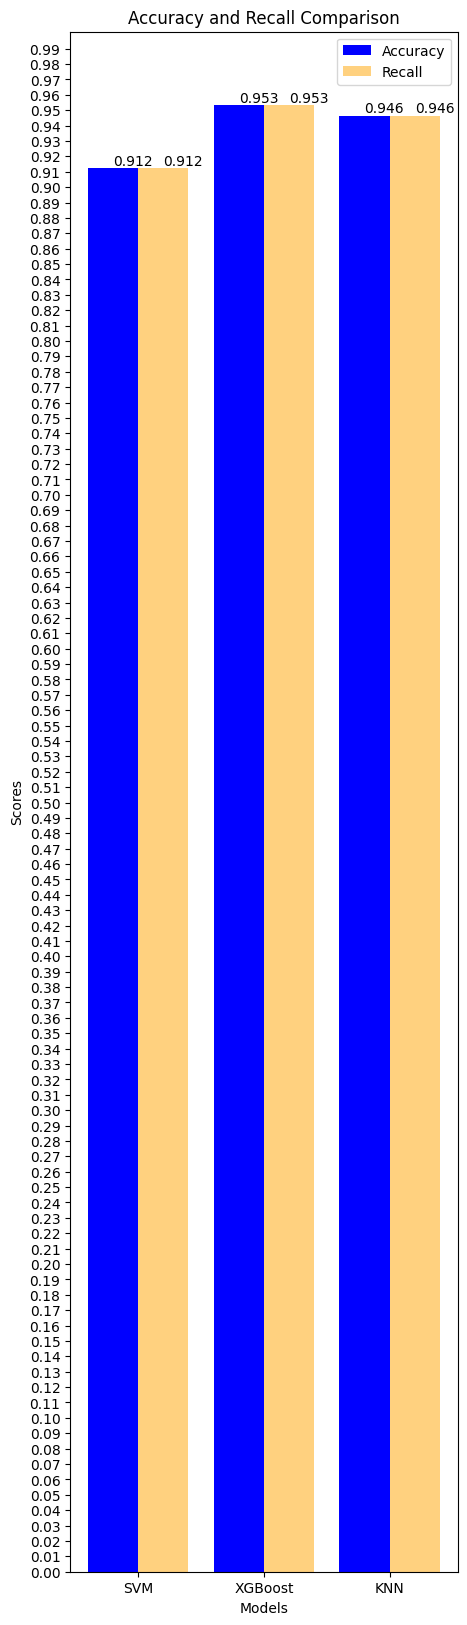

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

svm_accuracy = (svm_accuracy_l1 + svm_accuracy_l2) / 2
svm_recall = (svm_recall_l1 + svm_recall_l2) / 2
print("SVM accuracy: ", svm_accuracy)
print("SVM recall: ", svm_recall)

knn_accuracy = (knn_accuracy_l1 + knn_accuracy_l2) / 2
knn_recall = (knn_recall_l1 + knn_recall_l2) / 2
print("KNN accuracy: ", knn_accuracy)
print("KNN recall: ", knn_recall)

xgboost_accuracy = (xgboost_accuracy_l1 + xgboost_accuracy_l2) / 2
xgboost_recall = (xgboost_recall_l1 + xgboost_recall_l2) / 2
print("XGBoost accuracy: ", xgboost_accuracy)
print("XGBoost recall: ", xgboost_recall)

# Tên của các mô hình
models = ['SVM', 'XGBoost', 'KNN']

# Độ chính xác và recall tương ứng của từng mô hình
accuracy_scores = [svm_accuracy, xgboost_accuracy, knn_accuracy]
recall_scores = [svm_recall, xgboost_recall, knn_recall]

# Vị trí của các cột
x = np.arange(len(models))

# Kích thước của biểu đồ
width = 0.4

# Vẽ biểu đồ cột
plt.figure(figsize=(5, 20))

bars1 = plt.bar(x - width/2, accuracy_scores, color='blue', width=width, label='Accuracy')
bars2 = plt.bar(x + width/2, recall_scores, color='orange', alpha=0.5, width=width, label='Recall')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and Recall Comparison')
plt.legend()

# Chỉnh trục x
plt.xticks(ticks=x, labels=models)

# Chỉnh trục y
plt.yticks(np.arange(0, 1, 0.01 ))

# Hiển thị giá trị trên từng cột
for bar1, bar2 in zip(bars1, bars2):
    yval1 = bar1.get_height()
    plt.text(bar1.get_x() + bar1.get_width() / 2, yval1, round(yval1, 3), va='bottom')

    yval2 = bar2.get_height()
    plt.text(bar2.get_x() + bar2.get_width() / 2, yval2, round(yval2, 3), va='bottom')

plt.show()
